# Text Classification with Tensorflow 2
#### `Adapted from Rich Folsom article to include scikit-learn API and Confusion Matrix`
https://towardsdatascience.com/tensorflow-2-0-data-transformation-for-text-classification-b86ee2ad8877


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow import keras
import joblib
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ParameterGrid
import pandas as pd
import os
import time

pd.set_option('max_colwidth', 500)
print('tensorflow version:', tf.__version__)

tensorflow version: 2.1.0


In [2]:
mstart = time.time()

#### Helper function

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix  #Required input to plot_confusion_matrix
import seaborn as sns

# Inspired by Shay Palachy's function:  https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823
def plot_confusion_matrix(confusion_matrix, class_names, errors_only=False, figsize = (15,6), fontsize=16):
    """
    Plots confusion matrix as a color-encoded Seaborn heatmap.  Zeroes are
    colored white.  Normalized values that are zero when rounded to three
    decimals, Ex. 0.000, will be colored white.  Get more decicmals by
    updating fmt, for example to '0.4f', and updating get_text() value.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object sklearn.metrics.confusion_matrix. 
    class_names: list
        List of class names in the order they index the confusion matrix.
    figsize: tuple
        A pair tuple.  The first value is figure width.  The second
        value is figure height. Defaults to (15,6).
    fontsize: int
        Font size for axes labels. Defaults to 16.
    """        
    #Instantiate Figure
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    plt.subplots_adjust(wspace = 0.5)
    
    #Show errors only by filling diagonal with zeroes.
    if errors_only:
        np.fill_diagonal(confusion_matrix, 0)        
        
    # ax1 - Normalized Confusion Matrix    
    #Normalize by dividing (M X M) matrix by (M X 1) matrix.  (M X 1) is row totals.
    conf_matrix_norm = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:,np.newaxis]
    conf_matrix_norm = np.nan_to_num(conf_matrix_norm)  #fix any nans caused by zero row total
    df_cm_norm = pd.DataFrame(conf_matrix_norm, index=class_names, columns=class_names)
    heatmap = sns.heatmap(df_cm_norm, ax=ax1, cmap='Blues', fmt='.3f', annot=True, annot_kws={"size": fontsize},
              linewidths=2, linecolor='black', cbar=False)
    
    ax1.tick_params(axis='x', labelrotation=0, labelsize=fontsize, labelcolor='black')
    ax1.tick_params(axis='y', labelrotation=0, labelsize=fontsize, labelcolor='black')
    ax1.set_ylim(ax1.get_xlim()[0], ax1.get_xlim()[1])  #Fix messed up ylim
    ax1.set_xlabel('PREDICTED CLASS', fontsize=fontsize, color='black')
    ax1.set_ylabel('TRUE CLASS', fontsize=fontsize, color='black')
    ax1.set_title('Confusion Matrix - Normalized', pad=15, fontsize=fontsize, color='black')
    
    # ax2 - Confusion Matrix - Class Counts
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)    
    heatmap = sns.heatmap(df_cm, ax=ax2, cmap='Blues', fmt='d', annot=True, annot_kws={"size": fontsize},
              linewidths=2, linecolor='black', cbar=False)   
    
    ax2.tick_params(axis='x', labelrotation=0, labelsize=fontsize, labelcolor='black')
    ax2.tick_params(axis='y', labelrotation=0, labelsize=fontsize, labelcolor='black')
    ax2.set_ylim(ax1.get_xlim()[0], ax1.get_xlim()[1])  #Fix bug in matplotlib 3.1.1.  Or, use earlier matplotlib.
    ax2.set_xlabel('PREDICTED CLASS', fontsize=fontsize, color='black')
    ax2.set_ylabel('TRUE CLASS', fontsize=fontsize, color='black')
    ax2.set_title('Confusion Matrix - Class Counts', pad=15, fontsize=fontsize, color='black')    
  
    for text in ax1.texts:
        if text.get_text() == '0.000':
            text.set_color(color='white')            
    for text in ax2.texts:
        if text.get_text() == '0':
            text.set_color(color='white')

In [4]:
os.getcwd()

'C:\\Users\\Justin\\DATA_SCIENCE\\text_classification'

### Build train and test dataframes from individual review files

In [5]:
# #Build dataframes from train subfolders pos and neg.  Pos and neg contain reviews in individual text files.
# def build_df(start_path):
#     '''
#     Append all files in the target folder.  Then return as dataframe.
#     '''

#     df = pd.DataFrame(columns=['review', 'sentim'])
#     review = []
#     sentim = []
    
#     for folder in ['neg','pos']:
#         fpath=os.path.join(start_path, folder)
#         files = [f for f in os.listdir(fpath)]
        
#         for f in files:
#             with open(os.path.join(fpath, f), "r", encoding='utf8') as myfile:
#                 # replace linefeed (\n) and carriage return (\r) with space
#                 review.append(myfile.read().replace("\n", " ").replace("\r", " "))
#                 # convert positive reviews to 1 and negative reviews to zero
#                 sentim.append(1 if folder == 'pos' else 0)

#     df['review']=review
#     df['sentim']=sentim
#     #This line shuffles the data so you don't end with contiguous
#     #blocks of positive and negative reviews
#     df = df.sample(frac=1).reset_index(drop=True)      
#     return df

# #double backslash for Windows
# train_df = build_df('aclImdb\\train')
# test_df = build_df('aclImdb\\test')

# #Save dataframes to disk.  Delete dataframes from memory.
# joblib.dump(train_df, 'train_df.joblib', compress=1)
# joblib.dump(test_df, 'test_df.joblib', compress=1)
# del train_df
# del test_df

In [6]:
#Load dataframes from disk.
train_df = joblib.load('train_df.joblib')
test_df = joblib.load('test_df.joblib')

In [7]:
train_df.head(1)

,review,sentim
0,"Note: These comments are for people who have seen the movie.<br /><br />Vanilla Sky is a brilliant, complex, and thrilling movie that existentially explores exactly what the tag-line says: LoveHateDreamsLifeWorkPlayFriends. Maybe the movie plot can come into focus for confused movie-goers if one looks at it from a different angle.<br /><br />Considering the following:<br /><br />Now, I have not painstakingly gone through the film scene by scene, so I will have to further examine my assertion...",1


In [8]:
test_df.head(1)

,review,sentim
0,"This was an excellent show. It came on PBS back home in Chicago and I remember Cindy Herron (From EnVogue) played the teen aged daughter. The show dealt with subjects such as sex, peer pressure and puberty. IT was about a middle class black family who had a teen aged daughter and son who moved to a middle class neighborhood from Oakland or somewhere (I can't remember). I remember several episodes but the one I remember most was when their cousin got her period for the first time. I was proba...",1


## Convert text to numeric features

In [9]:
#Use keras tokenizer on reviews.  Need better tokenizer that uses the state-of-the-art cosine similarity?
def text_to_integer_seqs(train=train_df, test=test_df, vocabSize=8000, SEQ_LEN=256):
    '''
    Tokenize text in train and test.  Convert text to integer sequences.  Pad or truncate each
    sequence to SEQ_LEN.
    
    Returns numeric train and test.  Also returns tokenizer.
    '''
    #create tokenizer for our data
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocabSize, oov_token='<UNK>')
    tokenizer.fit_on_texts(train['review'])
    print(f"## length of word index dictionary: {len(tokenizer.word_index)}")
    print(f"## max number of most common words kept: {tokenizer.num_words}")
    
    #convert review texts to various length integer sequences.
    train_seqs=tokenizer.texts_to_sequences(train['review'])
    test_seqs=tokenizer.texts_to_sequences(test['review'])  #Is this right for test???
    print(f'## {len(train_seqs)} review texts are now integer sequences.')

    #Adjust sequence lengths to 256 by padding or truncating.
    train_seqs=tf.keras.preprocessing.sequence.pad_sequences(train_seqs, maxlen=SEQ_LEN, padding="post")
    test_seqs=tf.keras.preprocessing.sequence.pad_sequences(test_seqs, maxlen=SEQ_LEN, padding="post")
    print(f'## Length of first train seq: {len(train_seqs[0])}','\n')
    return train_seqs, test_seqs

In [10]:
# #Get model-friendly text features
# train_seqs, test_seqs = text_to_integer_seqs(train=train_df, test=test_df, vocabSize=8000, SEQ_LEN=256)

## Build Model Function

In [11]:
def build_model(vocabSize=8000, embeddedDim=4):
    
    #Embedding: The vocabul_size is the input_dim. EMBEDDING_DIM is the embedding dimensions.
    model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocabSize, embeddedDim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(1, activation='sigmoid')])

    print(model.summary())

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])    
    return model

### Hyperparameter Search

In [12]:
#Reset current tensorflow session, learning phase, and graph.
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

## Transparent Pipeline
#### `Note:  We could also do these steps with sklearn.pipeline.Pipeline`

In [13]:
#Grid search preprocessing in outer loop.  Random search model hyperparameters in "inner loop."
#Log the best model for each preprocessing grid.

preproc_grid = {'vocabSize': [8000], 'SEQ_LEN': [256, 512]}
pregrid = ParameterGrid(preproc_grid)

results = []

for p in pregrid:
    #Insert p parameters into text transformer "text_to_integer_seqs"
    vocabul_size = p['vocabSize']
    train_seqs, test_seqs = text_to_integer_seqs(train=train_df, test=test_df, **p)    
    
    #Hyperparameter search within pregrid loop.
    hyp_grid = {
    "vocabSize": [vocabul_size],
    "embeddedDim": [4,8,16],
    "batch_size": [16,32],
    "epochs": [20],    
    }

    #Callbacks - early stop and save best model
    early_stop_cb = keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max')
    checkpoint_cb_hpsearch = keras.callbacks.ModelCheckpoint("hyp_model.h5", save_best_only=True)

    #Use model like a Scikit-Learn object
    class_model = keras.wrappers.scikit_learn.KerasClassifier(build_model)

    hyp_model = RandomizedSearchCV(class_model, hyp_grid, n_iter=10, cv=3, verbose=2)

    hyp_model.fit(train_seqs, train_df['sentim'].values, validation_split=0.2, 
              callbacks=[early_stop_cb, checkpoint_cb_hpsearch])
    
    #Log pregrid, hyperparameters, and best score with standard deviation.
    results.append([p, hyp_model.best_params_, hyp_model.best_score_, 
                   hyp_model.cv_results_['std_test_score'][hyp_model.best_index_]])

## length of word index dictionary: 88581
## max number of most common words kept: 8000
## 25000 review texts are now integer sequences.
## Length of first train seq: 256 

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] vocabSize=8000, epochs=20, embeddedDim=4, batch_size=16 .........


C:\Users\Justin\Anaconda3\envs\tf2\lib\site-packages\sklearn\model_selection\_search.py:266: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 4)           32000     
_________________________________________________________________
global_average_pooling1d (Gl (None, 4)                 0         
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
Total params: 32,005
Trainable params: 32,005
Non-trainable params: 0
_________________________________________________________________
None
Train on 13332 samples, validate on 3334 samples
Epoch 1/20
13332/13332 [==============================] - 5s 370us/sample - loss: 0.6773 - accuracy: 0.6964 - val_loss: 0.6505 - val_accuracy: 0.7603
Epoch 2/20
13332/13332 [==============================] - 4s 277us/sample - loss: 0.6076 - accuracy: 0.7842 - val_loss: 0.5756 - val_accuracy: 0.7825
Epoch 3/20
13332/13332 [====

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   41.0s remaining:    0.0s


13333/13333 [==============================] - 4s 321us/sample - loss: 0.6813 - accuracy: 0.6639 - val_loss: 0.6580 - val_accuracy: 0.7555
Epoch 2/20
13333/13333 [==============================] - 4s 274us/sample - loss: 0.6167 - accuracy: 0.7844 - val_loss: 0.5816 - val_accuracy: 0.7921
Epoch 3/20
13333/13333 [==============================] - 4s 266us/sample - loss: 0.5352 - accuracy: 0.8175 - val_loss: 0.5116 - val_accuracy: 0.8212
Epoch 4/20
13333/13333 [==============================] - 4s 264us/sample - loss: 0.4655 - accuracy: 0.8441 - val_loss: 0.4559 - val_accuracy: 0.8383
Epoch 5/20
13333/13333 [==============================] - 4s 270us/sample - loss: 0.4102 - accuracy: 0.8624 - val_loss: 0.4139 - val_accuracy: 0.8503
Epoch 6/20
13333/13333 [==============================] - 4s 267us/sample - loss: 0.3683 - accuracy: 0.8740 - val_loss: 0.3834 - val_accuracy: 0.8542
Epoch 7/20
13333/13333 [==============================] - 4s 269us/sample - loss: 0.3356 - accuracy: 0.8847 - v

Train on 13333 samples, validate on 3334 samples
Epoch 1/20
13333/13333 [==============================] - 4s 317us/sample - loss: 0.6661 - accuracy: 0.6912 - val_loss: 0.6236 - val_accuracy: 0.7633
Epoch 2/20
13333/13333 [==============================] - 4s 283us/sample - loss: 0.5615 - accuracy: 0.8052 - val_loss: 0.5171 - val_accuracy: 0.8098
Epoch 3/20
13333/13333 [==============================] - 4s 285us/sample - loss: 0.4586 - accuracy: 0.8459 - val_loss: 0.4386 - val_accuracy: 0.8455
Epoch 4/20
13333/13333 [==============================] - 4s 283us/sample - loss: 0.3858 - accuracy: 0.8700 - val_loss: 0.3880 - val_accuracy: 0.8554
Epoch 5/20
13333/13333 [==============================] - 4s 284us/sample - loss: 0.3361 - accuracy: 0.8854 - val_loss: 0.3559 - val_accuracy: 0.8629
Epoch 6/20
13333/13333 [==============================] - 4s 273us/sample - loss: 0.3013 - accuracy: 0.8955 - val_loss: 0.3357 - val_accuracy: 0.8674
Epoch 7/20
13333/13333 [===========================

13333/13333 [==============================] - 4s 298us/sample - loss: 0.4999 - accuracy: 0.8272 - val_loss: 0.4513 - val_accuracy: 0.8335
Epoch 3/20
13333/13333 [==============================] - 4s 289us/sample - loss: 0.3870 - accuracy: 0.8669 - val_loss: 0.3786 - val_accuracy: 0.8572
Epoch 4/20
13333/13333 [==============================] - 4s 291us/sample - loss: 0.3220 - accuracy: 0.8861 - val_loss: 0.3415 - val_accuracy: 0.8668
Epoch 5/20
13333/13333 [==============================] - 4s 284us/sample - loss: 0.2805 - accuracy: 0.9011 - val_loss: 0.3205 - val_accuracy: 0.8713
Epoch 6/20
13333/13333 [==============================] - 4s 282us/sample - loss: 0.2511 - accuracy: 0.9112 - val_loss: 0.3089 - val_accuracy: 0.8758
Epoch 7/20
8333/8333 [==============================] - 1s 124us/sample - loss: 0.2938 - accuracy: 0.8848
[CV]  vocabSize=8000, epochs=20, embeddedDim=16, batch_size=16, total=  28.8s
[CV] vocabSize=8000, epochs=20, embeddedDim=16, batch_size=16 ........
Model:

13333/13333 [==============================] - 2s 133us/sample - loss: 0.4671 - accuracy: 0.8465 - val_loss: 0.4686 - val_accuracy: 0.8353
Epoch 7/20
13333/13333 [==============================] - 2s 134us/sample - loss: 0.4314 - accuracy: 0.8585 - val_loss: 0.4395 - val_accuracy: 0.8455
Epoch 8/20
13333/13333 [==============================] - 2s 133us/sample - loss: 0.4009 - accuracy: 0.8685 - val_loss: 0.4155 - val_accuracy: 0.8515
Epoch 9/20
13333/13333 [==============================] - 2s 135us/sample - loss: 0.3750 - accuracy: 0.8753 - val_loss: 0.3960 - val_accuracy: 0.8542
Epoch 10/20
13333/13333 [==============================] - 2s 141us/sample - loss: 0.3529 - accuracy: 0.8826 - val_loss: 0.3794 - val_accuracy: 0.8599
Epoch 11/20
13333/13333 [==============================] - 2s 141us/sample - loss: 0.3339 - accuracy: 0.8892 - val_loss: 0.3648 - val_accuracy: 0.8614
Epoch 12/20
13333/13333 [==============================] - 2s 134us/sample - loss: 0.3172 - accuracy: 0.8930 

[CV]  vocabSize=8000, epochs=20, embeddedDim=8, batch_size=32, total=  26.5s
[CV] vocabSize=8000, epochs=20, embeddedDim=8, batch_size=32 .........
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, None, 8)           64000     
_________________________________________________________________
global_average_pooling1d_13  (None, 8)                 0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 64,009
Trainable params: 64,009
Non-trainable params: 0
_________________________________________________________________
None
Train on 13333 samples, validate on 3334 samples
Epoch 1/20
13333/13333 [==============================] - 2s 183us/sample - loss: 0.6809 - accuracy: 0.6837 - val_loss: 0.6610 - val_accuracy: 0.7594
Epoch 2/20
13333/13333 [===

13332/13332 [==============================] - 2s 167us/sample - loss: 0.5906 - accuracy: 0.7853 - val_loss: 0.5518 - val_accuracy: 0.7903
Epoch 3/20
13332/13332 [==============================] - 2s 171us/sample - loss: 0.4950 - accuracy: 0.8304 - val_loss: 0.4720 - val_accuracy: 0.8314
Epoch 4/20
13332/13332 [==============================] - 2s 163us/sample - loss: 0.4205 - accuracy: 0.8592 - val_loss: 0.4168 - val_accuracy: 0.8506
Epoch 5/20
13332/13332 [==============================] - 2s 158us/sample - loss: 0.3674 - accuracy: 0.8764 - val_loss: 0.3792 - val_accuracy: 0.8596
Epoch 6/20
13332/13332 [==============================] - 2s 158us/sample - loss: 0.3291 - accuracy: 0.8879 - val_loss: 0.3555 - val_accuracy: 0.8668
Epoch 7/20
13332/13332 [==============================] - 2s 158us/sample - loss: 0.3001 - accuracy: 0.8975 - val_loss: 0.3373 - val_accuracy: 0.8695
Epoch 8/20
13332/13332 [==============================] - 2s 158us/sample - loss: 0.2770 - accuracy: 0.9058 - v

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 10.3min finished


20000/20000 [==============================] - 5s 266us/sample - loss: 0.6189 - accuracy: 0.7307 - val_loss: 0.5161 - val_accuracy: 0.8168
Epoch 2/20
20000/20000 [==============================] - 5s 243us/sample - loss: 0.4236 - accuracy: 0.8509 - val_loss: 0.3864 - val_accuracy: 0.8564
Epoch 3/20
20000/20000 [==============================] - 5s 248us/sample - loss: 0.3258 - accuracy: 0.8816 - val_loss: 0.3347 - val_accuracy: 0.8686
Epoch 4/20
20000/20000 [==============================] - 5s 234us/sample - loss: 0.2774 - accuracy: 0.8977 - val_loss: 0.3087 - val_accuracy: 0.8778
Epoch 5/20
20000/20000 [==============================] - 5s 234us/sample - loss: 0.2462 - accuracy: 0.9097 - val_loss: 0.2986 - val_accuracy: 0.8810
Epoch 6/20
20000/20000 [==============================] - 5s 235us/sample - loss: 0.2237 - accuracy: 0.9184 - val_loss: 0.2908 - val_accuracy: 0.8854
Epoch 7/20
20000/20000 [==============================] - 5s 239us/sample - loss: 0.2050 - accuracy: 0.9248 - v

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


13332/13332 [==============================] - 4s 332us/sample - loss: 0.6833 - accuracy: 0.6304 - val_loss: 0.6694 - val_accuracy: 0.7034
Epoch 2/20
13332/13332 [==============================] - 4s 290us/sample - loss: 0.6432 - accuracy: 0.7482 - val_loss: 0.6234 - val_accuracy: 0.7070
Epoch 3/20
13332/13332 [==============================] - 4s 289us/sample - loss: 0.5873 - accuracy: 0.7893 - val_loss: 0.5692 - val_accuracy: 0.7963
Epoch 4/20
13332/13332 [==============================] - 4s 276us/sample - loss: 0.5320 - accuracy: 0.8174 - val_loss: 0.5218 - val_accuracy: 0.8170
Epoch 5/20
13332/13332 [==============================] - 4s 277us/sample - loss: 0.4831 - accuracy: 0.8420 - val_loss: 0.4795 - val_accuracy: 0.8341
Epoch 6/20
13332/13332 [==============================] - 4s 276us/sample - loss: 0.4406 - accuracy: 0.8587 - val_loss: 0.4446 - val_accuracy: 0.8467
Epoch 7/20
13332/13332 [==============================] - 4s 294us/sample - loss: 0.4049 - accuracy: 0.8711 - v

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s


13333/13333 [==============================] - 4s 322us/sample - loss: 0.6850 - accuracy: 0.6224 - val_loss: 0.6735 - val_accuracy: 0.6632
Epoch 2/20
13333/13333 [==============================] - 4s 286us/sample - loss: 0.6498 - accuracy: 0.7361 - val_loss: 0.6282 - val_accuracy: 0.7726
Epoch 3/20
13333/13333 [==============================] - 4s 278us/sample - loss: 0.5947 - accuracy: 0.7921 - val_loss: 0.5749 - val_accuracy: 0.7954
Epoch 4/20
13333/13333 [==============================] - 4s 277us/sample - loss: 0.5382 - accuracy: 0.8176 - val_loss: 0.5258 - val_accuracy: 0.8188
Epoch 5/20
13333/13333 [==============================] - 4s 275us/sample - loss: 0.4872 - accuracy: 0.8399 - val_loss: 0.4831 - val_accuracy: 0.8356
Epoch 6/20
13333/13333 [==============================] - 4s 274us/sample - loss: 0.4439 - accuracy: 0.8551 - val_loss: 0.4483 - val_accuracy: 0.8416
Epoch 7/20
13333/13333 [==============================] - 4s 282us/sample - loss: 0.4068 - accuracy: 0.8672 - v

13333/13333 [==============================] - 4s 301us/sample - loss: 0.5497 - accuracy: 0.8081 - val_loss: 0.5249 - val_accuracy: 0.8194
Epoch 4/20
13333/13333 [==============================] - 4s 293us/sample - loss: 0.4779 - accuracy: 0.8384 - val_loss: 0.4661 - val_accuracy: 0.8371
Epoch 5/20
13333/13333 [==============================] - 4s 288us/sample - loss: 0.4199 - accuracy: 0.8605 - val_loss: 0.4208 - val_accuracy: 0.8557
Epoch 6/20
13333/13333 [==============================] - 4s 289us/sample - loss: 0.3760 - accuracy: 0.8747 - val_loss: 0.3898 - val_accuracy: 0.8566
Epoch 7/20
13333/13333 [==============================] - 4s 294us/sample - loss: 0.3417 - accuracy: 0.8854 - val_loss: 0.3631 - val_accuracy: 0.8665
Epoch 8/20
13333/13333 [==============================] - 4s 293us/sample - loss: 0.3149 - accuracy: 0.8936 - val_loss: 0.3442 - val_accuracy: 0.8710
Epoch 9/20
13333/13333 [==============================] - 4s 287us/sample - loss: 0.2927 - accuracy: 0.8990 - v

8333/8333 [==============================] - 1s 132us/sample - loss: 0.3028 - accuracy: 0.8837
[CV]  vocabSize=8000, epochs=20, embeddedDim=16, batch_size=16, total=  39.1s
[CV] vocabSize=8000, epochs=20, embeddedDim=16, batch_size=16 ........
Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_27 (Embedding)     (None, None, 16)          128000    
_________________________________________________________________
global_average_pooling1d_27  (None, 16)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 17        
Total params: 128,017
Trainable params: 128,017
Non-trainable params: 0
_________________________________________________________________
None
Train on 13333 samples, validate on 3334 samples
Epoch 1/20
13333/13333 [==============================] - 5s 366us/sample - los

13333/13333 [==============================] - 3s 197us/sample - loss: 0.6898 - accuracy: 0.5897 - val_loss: 0.6844 - val_accuracy: 0.7445
Epoch 2/20
13333/13333 [==============================] - 2s 162us/sample - loss: 0.6725 - accuracy: 0.7095 - val_loss: 0.6609 - val_accuracy: 0.7540
Epoch 3/20
13333/13333 [==============================] - 2s 161us/sample - loss: 0.6416 - accuracy: 0.7657 - val_loss: 0.6287 - val_accuracy: 0.7663
Epoch 4/20
13333/13333 [==============================] - 2s 162us/sample - loss: 0.6052 - accuracy: 0.7901 - val_loss: 0.5951 - val_accuracy: 0.7792
Epoch 5/20
13333/13333 [==============================] - 2s 161us/sample - loss: 0.5686 - accuracy: 0.8045 - val_loss: 0.5630 - val_accuracy: 0.7954
Epoch 6/20
13333/13333 [==============================] - 2s 153us/sample - loss: 0.5345 - accuracy: 0.8192 - val_loss: 0.5330 - val_accuracy: 0.8134
Epoch 7/20
13333/13333 [==============================] - 2s 153us/sample - loss: 0.5026 - accuracy: 0.8327 - v

13332/13332 [==============================] - 2s 160us/sample - loss: 0.4367 - accuracy: 0.8583 - val_loss: 0.4444 - val_accuracy: 0.8437
Epoch 8/20
13332/13332 [==============================] - 2s 168us/sample - loss: 0.4060 - accuracy: 0.8685 - val_loss: 0.4188 - val_accuracy: 0.8551
Epoch 9/20
13332/13332 [==============================] - 2s 158us/sample - loss: 0.3794 - accuracy: 0.8761 - val_loss: 0.3973 - val_accuracy: 0.8590
Epoch 10/20
13332/13332 [==============================] - 2s 159us/sample - loss: 0.3567 - accuracy: 0.8850 - val_loss: 0.3792 - val_accuracy: 0.8695
Epoch 11/20
8334/8334 [==============================] - 1s 71us/sample - loss: 0.3530 - accuracy: 0.8733
[CV]  vocabSize=8000, epochs=20, embeddedDim=8, batch_size=32, total=  25.5s
[CV] vocabSize=8000, epochs=20, embeddedDim=8, batch_size=32 .........
Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
e

Train on 13332 samples, validate on 3334 samples
Epoch 1/20
13332/13332 [==============================] - 3s 217us/sample - loss: 0.6835 - accuracy: 0.6346 - val_loss: 0.6684 - val_accuracy: 0.6728
Epoch 2/20
13332/13332 [==============================] - 2s 181us/sample - loss: 0.6358 - accuracy: 0.7478 - val_loss: 0.6103 - val_accuracy: 0.7154
Epoch 3/20
13332/13332 [==============================] - 2s 182us/sample - loss: 0.5658 - accuracy: 0.7967 - val_loss: 0.5439 - val_accuracy: 0.8056
Epoch 4/20
13332/13332 [==============================] - 2s 177us/sample - loss: 0.4996 - accuracy: 0.8308 - val_loss: 0.4892 - val_accuracy: 0.8254
Epoch 5/20
13332/13332 [==============================] - 2s 172us/sample - loss: 0.4446 - accuracy: 0.8564 - val_loss: 0.4432 - val_accuracy: 0.8479
Epoch 6/20
13332/13332 [==============================] - 2s 172us/sample - loss: 0.4004 - accuracy: 0.8706 - val_loss: 0.4098 - val_accuracy: 0.8566
Epoch 7/20
13332/13332 [===========================

Train on 20000 samples, validate on 5000 samples
Epoch 1/20


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 11.6min finished


20000/20000 [==============================] - 4s 196us/sample - loss: 0.6750 - accuracy: 0.6586 - val_loss: 0.6409 - val_accuracy: 0.7544
Epoch 2/20
20000/20000 [==============================] - 3s 170us/sample - loss: 0.5838 - accuracy: 0.7919 - val_loss: 0.5412 - val_accuracy: 0.8032
Epoch 3/20
20000/20000 [==============================] - 3s 166us/sample - loss: 0.4850 - accuracy: 0.8365 - val_loss: 0.4642 - val_accuracy: 0.8352
Epoch 4/20
20000/20000 [==============================] - 3s 166us/sample - loss: 0.4122 - accuracy: 0.8632 - val_loss: 0.4071 - val_accuracy: 0.8554
Epoch 5/20
20000/20000 [==============================] - 3s 166us/sample - loss: 0.3620 - accuracy: 0.8760 - val_loss: 0.3718 - val_accuracy: 0.8646
Epoch 6/20
20000/20000 [==============================] - 3s 173us/sample - loss: 0.3266 - accuracy: 0.8873 - val_loss: 0.3464 - val_accuracy: 0.8706
Epoch 7/20
20000/20000 [==============================] - 3s 166us/sample - loss: 0.3001 - accuracy: 0.8945 - v

In [14]:
hyp_model.best_params_ 

{'vocabSize': 8000, 'epochs': 20, 'embeddedDim': 16, 'batch_size': 32}

In [15]:
results_df = pd.DataFrame(results, columns=['preproc','best_hyp','best_score','std_score']).sort_values(by=['best_score','std_score'], ascending=False)
results_df

,preproc,best_hyp,best_score,std_score
0,"{'SEQ_LEN': 256, 'vocabSize': 8000}","{'vocabSize': 8000, 'epochs': 20, 'embeddedDim': 16, 'batch_size': 16}",0.88108,0.006400
1,"{'SEQ_LEN': 512, 'vocabSize': 8000}","{'vocabSize': 8000, 'epochs': 20, 'embeddedDim': 16, 'batch_size': 32}",0.88100,0.002305


#### In results_df above, we see the hyp_model best scores are about the same for 256 and 512 features.  But, the standard deviation of scores across three folds is much lower with more (512) features.


In [16]:
pd.DataFrame(hyp_model.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_vocabSize,param_epochs,param_embeddedDim,param_batch_size,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,57.770239,4.948184,1.086663,0.026641,8000,20,4,16,"{'vocabSize': 8000, 'epochs': 20, 'embeddedDim': 4, 'batch_size': 16}",0.889249,0.878675,0.875075,0.88100,0.006015,2
1,35.800542,19.171604,1.113650,0.038522,8000,20,8,16,"{'vocabSize': 8000, 'epochs': 20, 'embeddedDim': 8, 'batch_size': 16}",0.730742,0.882035,0.878675,0.83048,0.070543,6
2,32.643747,17.277465,1.173160,0.051229,8000,20,16,16,"{'vocabSize': 8000, 'epochs': 20, 'embeddedDim': 16, 'batch_size': 16}",0.766019,0.883715,0.880955,0.84356,0.054845,5
3,38.087873,5.843045,0.579464,0.010247,8000,20,4,32,"{'vocabSize': 8000, 'epochs': 20, 'embeddedDim': 4, 'batch_size': 32}",0.882289,0.867395,0.873275,0.87432,0.006126,4
4,31.411162,5.202384,0.599832,0.022554,8000,20,8,32,"{'vocabSize': 8000, 'epochs': 20, 'embeddedDim': 8, 'batch_size': 32}",0.873290,0.875795,0.875915,0.87500,0.001210,3
5,30.165508,3.851781,0.611267,0.007295,8000,20,16,32,"{'vocabSize': 8000, 'epochs': 20, 'embeddedDim': 16, 'batch_size': 32}",0.884089,0.880355,0.878555,0.88100,0.002305,1


In [17]:
#Get prediction in probability format.  Convert to binary.
test_preds = hyp_model.predict(test_seqs)
test_pred_ints = [int(i>0.5) for i in test_preds]

#Calc sklearn metrics on test data
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# precision = tp / (tp + fp)
# recall = tp / (tp + fn)
print('sklearn accuracy:', round(accuracy_score(test_df['sentim'].values, test_pred_ints),3))
print('precision - avoid false positives:', round(precision_score(test_df['sentim'].values, test_pred_ints),3))
print('recall - find all positives:', round(recall_score(test_df['sentim'].values, test_pred_ints),3))

sklearn accuracy: 0.883
precision - avoid false positives: 0.9
recall - find all positives: 0.863


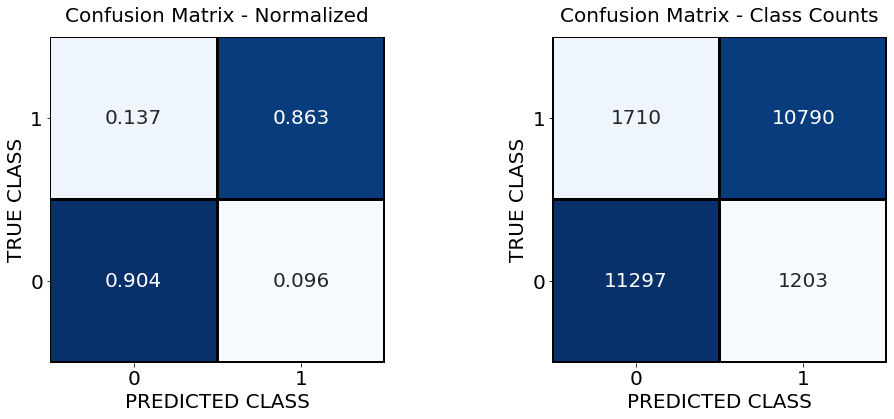

In [18]:
#Compute confusion matrix: confusion_matrix(y_true, y_pred)
class_labels = [0,1]
cm=confusion_matrix(test_df['sentim'].values, test_pred_ints, labels=class_labels)
plot_confusion_matrix(confusion_matrix=cm, class_names=class_labels, fontsize=20)

In [19]:
#Predict sentiment of four new reviews.  
#Sentiment: 1 - Positive or 0 - Negative.

def prepare_predict_data(reviews):
    '''
    Convert review texts to integer sequences.  Adjust each sequence
    to maxlen by padding or truncating.
    '''
      
    #create tokenizer for our data
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=8000, oov_token='<UNK>')
    tokenizer.fit_on_texts(train_df['review'])
    
    seqs = tokenizer.texts_to_sequences(reviews)
    seqs = tf.keras.preprocessing.sequence.pad_sequences(seqs, maxlen=256, padding="post")
    return seqs

my_reviews=['this movie was awesome',
           'this movie was the worst movie ive ever seen',
           'i hated everything about this movie.  it was a waste.',
           'this is my favorite movie of the year']
my_seqs = prepare_predict_data(my_reviews)

new_preds= hyp_model.predict(my_seqs)
new_preds_int = [int(i>0.5) for i in new_preds]

#Summarize new reviews and predictions in dataframe.
wild_df = pd.DataFrame(columns=['reviews','sentim_pred'])
wild_df['reviews'] = my_reviews
wild_df['sentim_pred'] = new_preds_int
wild_df['sentim_pred'].replace({1: 'pos', 0: 'neg'}, inplace=True)
wild_df

,reviews,sentim_pred
0,this movie was awesome,pos
1,this movie was the worst movie ive ever seen,neg
2,i hated everything about this movie. it was a waste.,neg
3,this is my favorite movie of the year,pos


In [20]:
mend=time.time()
print('model runtime:', (mend-mstart)/60)

model runtime: 23.653537011146547


In [21]:
#Beep when code is done.
from IPython.display import Audio
sound_file = 'https://www.soundjay.com/button/sounds/beep-07.mp3'
Audio(sound_file, autoplay=True)

### https://www.tensorflow.org/tutorials/text/word_embeddings

### https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

In [22]:
# #Reset current tensorflow session, learning phase, and graph.
# keras.backend.clear_session()
# np.random.seed(42)
# tf.random.set_seed(42)

# #Use model like a Scikit-Learn object
# model = keras.wrappers.scikit_learn.KerasClassifier(build_model)

# #Callbacks - early stop and save best model
# early_stop_cb = keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max')
# checkpoint_cb = keras.callbacks.ModelCheckpoint("model.h5", save_best_only=True)

# #Fit TensorFlow 2 model.
# history = model.fit(train_seqs, train_df['sentim'].values, batch_size=BATCH_SIZE,
#                     epochs=EPOCHS, validation_split=0.2, callbacks=[early_stop_cb, checkpoint_cb])

# print(history.params)

In [23]:
# hyp_grid = {
#     "vocabSize": [8000], #can this be reduced?
#     "embeddedDim": [4,8],
#     "batch_size": [16, 32],
#     "epochs": [20],    
# }

# #Callbacks - early stop and save best model
# early_stop_cb = keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max')
# checkpoint_cb_hpsearch = keras.callbacks.ModelCheckpoint("hyp_model.h5", save_best_only=True)

# #Use model like a Scikit-Learn object
# class_model = keras.wrappers.scikit_learn.KerasClassifier(build_model)

# hyp_model = RandomizedSearchCV(class_model, hyp_grid, n_iter=2, cv=3, verbose=2)

# hyp_model.fit(train_seqs, train_df['sentim'].values, validation_split=0.2, 
#               callbacks=[early_stop_cb, checkpoint_cb_hpsearch])

In [24]:
# #hyp_model best parameters and score
# print('best params:', hyp_model.best_params_, '\n')
# best_score_std = hyp_model.cv_results_['std_test_score'][hyp_model.best_index_]
# print(f'best score: {hyp_model.best_score_:.4f} +/- {best_score_std:.5f}')